In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import preprocessing 

df = pd.read_parquet('data/df_log.parquet.gzip')
df = df.convert_dtypes()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89054 entries, 0 to 89053
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype                    
---  ------      --------------  -----                    
 0   ip          89054 non-null  string                   
 1   time        89054 non-null  datetime64[ns, UTC-03:00]
 2   request     89054 non-null  string                   
 3   status      89054 non-null  Int64                    
 4   size        89054 non-null  Int64                    
 5   Referer     16769 non-null  string                   
 6   User_agent  88973 non-null  string                   
 7   spambot     89054 non-null  boolean                  
dtypes: Int64(2), boolean(1), datetime64[ns, UTC-03:00](1), string(4)
memory usage: 5.1 MB


In [2]:
df.head(5)

,ip,time,request,status,size,Referer,User_agent,spambot
0,3.224.220.101,2022-03-31 00:00:13-03:00,GET /handle/10915/60216/browse?authority=http%...,200,7165,<NA>,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,True
1,173.252.107.9,2022-03-31 00:00:13-03:00,GET /handle/10915/45833 HTTP/1.1,200,9539,<NA>,facebookexternalhit/1.1 (+http://www.facebook....,True
2,173.252.107.3,2022-03-31 00:00:13-03:00,GET /handle/10915/31292 HTTP/1.1,200,9512,<NA>,facebookexternalhit/1.1 (+http://www.facebook....,True
3,173.252.107.22,2022-03-31 00:00:14-03:00,GET /handle/10915/66507 HTTP/1.1,200,10170,<NA>,facebookexternalhit/1.1 (+http://www.facebook....,True
4,173.252.107.9,2022-03-31 00:00:14-03:00,GET /handle/10915/66507 HTTP/1.1,200,10170,<NA>,facebookexternalhit/1.1 (+http://www.facebook....,True


In [3]:
df_groupby_ip = df.groupby(['ip','spambot'], as_index=False).size().rename(columns={'size':'count'}) # agrupo por ip y agrego un columna count con la cantidad de requests hechas 
df_groupby_ip['size'] = df.groupby(['ip','spambot'], as_index=False)['size'].sum()['size'] # agrego a df_groupby_ip una columna con la cantidad de bytes descargados en un día
df_groupby_ip

,ip,spambot,count,size
0,1.38.188.99,False,1,712495
1,1.47.151.27,False,2,1630020
2,1.85.11.244,False,1,497562
3,100.24.12.213,False,2,13623
4,101.108.5.245,False,1,7725352
...,...,...,...,...
8900,98.126.219.75,False,2,1184056
8901,98.167.168.137,False,2,224700
8902,98.176.225.232,False,2,14582
8903,99.150.195.19,False,6,53034


In [10]:
df_groupby_ip.dtypes

ip          string
spambot    boolean
count        int64
size         Int64
dtype: object

### Graficando los datos en escala original


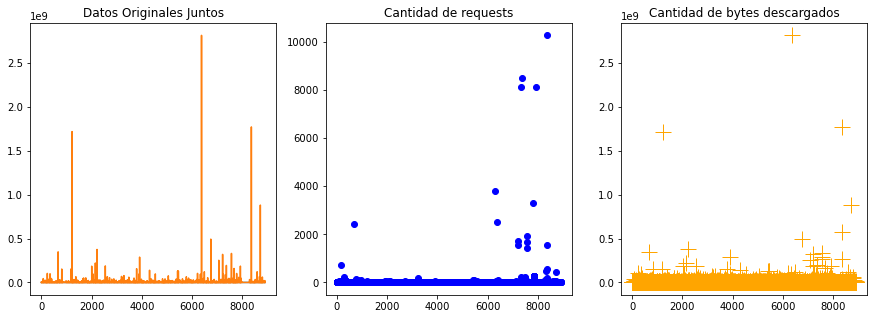

In [5]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
ax1.set_title("Datos Originales Juntos")
ax1.plot(df_groupby_ip[['count','size']])
ax2.set_title("Cantidad de requests")
ax2.plot(df_groupby_ip["count"], linewidth=0, marker="o", color="blue", markersize=6)
ax3.set_title("Cantidad de bytes descargados")
ax3.plot(df_groupby_ip["size"], linewidth=0, marker="+", color="orange", markersize=16)
plt.show()

#datos_robust_scaler = pd.DataFrame(datos_robust_scaler, columns=["ingreso", "carros"])


### Distribución de los datos originales

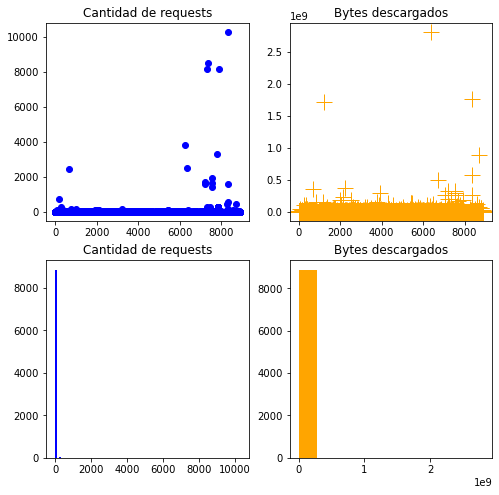

In [6]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
ax1.set_title("Cantidad de requests")
ax1.plot(df_groupby_ip["count"], linewidth=0, marker="o", color="blue", markersize=6)
ax2.set_title("Bytes descargados")
ax2.plot(df_groupby_ip["size"], linewidth=0, marker="+", color="orange", markersize=16)
ax3.set_title("Cantidad de requests")
ax3.hist(df_groupby_ip["count"], bins=100, color="blue")
ax4.set_title("Bytes descargados")
ax4.hist(df_groupby_ip["size"], color="orange")
plt.show()

In [12]:
datos_robust_scaler = preprocessing.RobustScaler().fit_transform(df_groupby_ip[["count", "size"]])
datos_robust_scaler = pd.DataFrame(datos_robust_scaler, columns=["count", "size"])


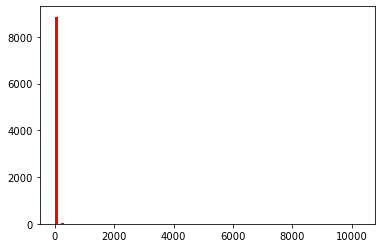

In [14]:
plt.hist(datos_robust_scaler["count"], color="red", bins=100)
plt.show()

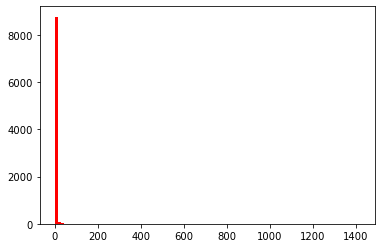

In [15]:
plt.hist(datos_robust_scaler["size"], color="red", bins=100)
plt.show()

In [16]:
df_co = df_groupby_ip.iloc[:,1:]
df_co

,spambot,count,size
0,False,1,712495
1,False,2,1630020
2,False,1,497562
3,False,2,13623
4,False,1,7725352
...,...,...,...
8900,False,2,1184056
8901,False,2,224700
8902,False,2,14582
8903,False,6,53034


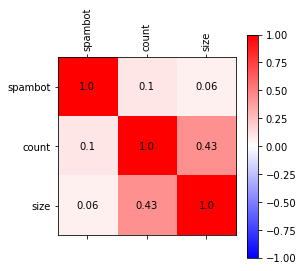

In [18]:
matriz = df_co.corr() # -1 (existe una relación fuerte)  0   1 (existe relación fuerte)
plt.matshow(matriz, cmap="bwr", vmin=-1, vmax=1)
plt.xticks(range(3), df_co.columns, rotation=90)
plt.yticks(range(3), df_co.columns)

for i in range(len(matriz.columns)):
    for j in range(len(matriz.columns)):
        plt.text(i, j, round(matriz.iloc[i, j], 2),
                 ha="center", va="center")


plt.colorbar()
plt.show()